#### Predicting Term Deposit

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing Data Auditor custom made function
class Data_Auditor:
    def NA_in_Data(data_frame):
        result = (data_frame.isnull().sum().sum()) / (data_frame.shape[0] * data_frame.shape[1]) * 100
        return(print("Data has",round(result,2),"% NA's"))

    def Remove_Columns(data_frame,*args):
        list_of_cols = list(args)
        data_frame.drop(list_of_cols,axis = 1,inplace = True)

    def NA_in_Columns(data_frame):
        total_missing = data_frame.isnull().sum().sort_values(ascending=False)
        percent_missing = round(((data_frame.isnull().sum()/data_frame.isnull().count()).sort_values(ascending=False)*100),1)
        missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Missing_Obs', 'Percent_of_NA'])
        return(missing_data.head(10))

    def Most_Frequent_Data(data_frame,Column):
        Count = data_frame[Column].value_counts()
        Percentage = round(((data_frame[Column].value_counts()/data_frame.shape[0])*100),2)
        Summary_data = pd.concat([Count, Percentage], axis=1, keys=['Count','Percentage'])
        return(Summary_data)

    def Remove_Outlier(data_frame,low,high):
        quant_df = data_frame.quantile([low, high])
        for cols in list(data_frame.columns):
            if data_frame[cols].dtypes == 'float64' or data_frame[cols].dtypes == 'int64':
                df = data_frame[(data_frame[cols] > quant_df.loc[low, cols]) & (data_frame[cols] < quant_df.loc[high, cols])]
                return(df)

    def Remove_Multicollinearity(data_frame,threshold):
        corr_matrix = data_frame.corr().abs() # Create correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # Select upper triangle of correlation matrix
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]# Find features with correlation greater than threshold
        data_frame.drop(to_drop, axis=1, inplace=True)# Drop features
        print(to_drop,'is removed')

In [3]:
term=pd.read_csv(r"C:\Users\Vicky Yewle\Downloads\Machine Learning\SVM\PredictingTermDepositSubscriptionbyaclient\Predicting Term Deposit Subscription by a client\Dataset\bank-additional-full.csv",delimiter=';')
term

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
term.shape
term.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
term_object = term.select_dtypes(include=[object])
term_num = term.select_dtypes(exclude=[object])

In [6]:
term_object.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [7]:
for cols in term_object.columns:
    print(term_object[cols].value_counts())
    print('-----------------------------')

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
-----------------------------
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
-----------------------------
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
-----------------------------
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
-----------------------------
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
-----------------------------
no         33950
yes         6

In [8]:
for columns in term_object.columns:
    term[columns]=term[columns].str.replace('unknown',term[columns].mode()[0])

In [9]:
for cols in term_object.columns:
    print(term[cols].value_counts())
    print('-----------------------------')

admin.           10752
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64
-----------------------------
married     25008
single      11568
divorced     4612
Name: marital, dtype: int64
-----------------------------
university.degree      13899
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64
-----------------------------
no     41185
yes        3
Name: default, dtype: int64
-----------------------------
yes    22566
no     18622
Name: housing, dtype: int64
-----------------------------
no     34940
yes     6248
Name: loan, dtype: int64
-----------------------------
cellular     26144
telephone    15044
Name: contact, dtype: int64
---

In [10]:
term_object = term.select_dtypes(include=[object])
term_num = term.select_dtypes(exclude=[object])

In [11]:
print(term_object.shape)
term_object = pd.get_dummies(term_object, drop_first= True)
print(term_object.shape)

(41188, 11)
(41188, 38)


In [12]:
P_days_term = pd.DataFrame()

col = 'P_days'
conditions =  [ term_num['pdays']>= 999, (term_num['pdays']<= 10) &(term_num['pdays']>0),
                (term_num['pdays']<=20) & (term_num['pdays']>10),
              term_num['pdays']>20 ]
choices    = ['Not_Contacted','Contacted_0_to_10','Contacted_11_to_20','Contacted_21_and_above']

P_days_term["P_days"]= np.select(conditions, choices, default="Not_Contacted")
P_days_term["P_days"]

0        Not_Contacted
1        Not_Contacted
2        Not_Contacted
3        Not_Contacted
4        Not_Contacted
             ...      
41183    Not_Contacted
41184    Not_Contacted
41185    Not_Contacted
41186    Not_Contacted
41187    Not_Contacted
Name: P_days, Length: 41188, dtype: object

In [13]:
P_days_term = pd.get_dummies(P_days_term,drop_first=True)


In [14]:
term_object = pd.concat([term_object,P_days_term], axis=1)
del term_num['pdays']

In [15]:
term=pd.concat([term_object, term_num], axis= 1)

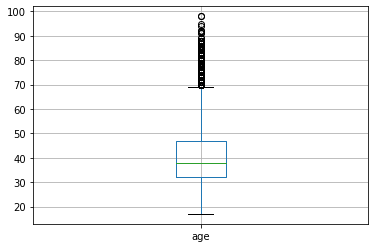

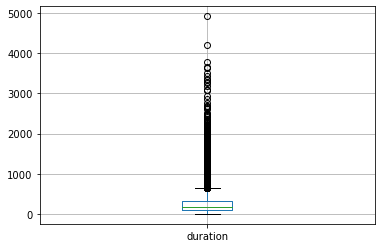

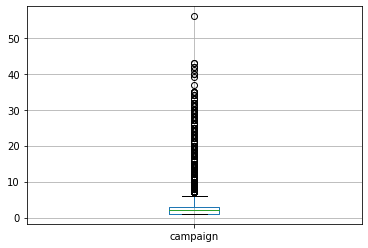

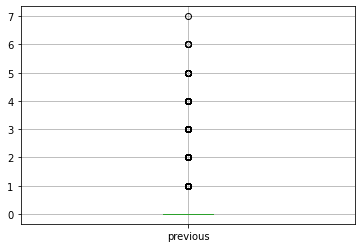

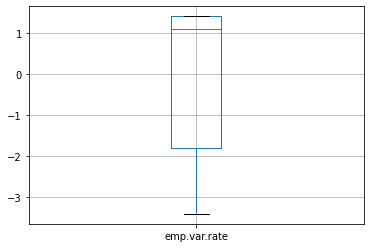

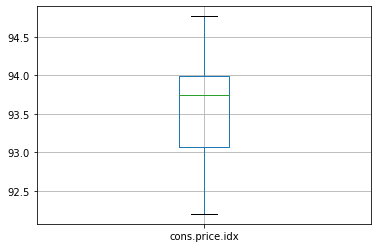

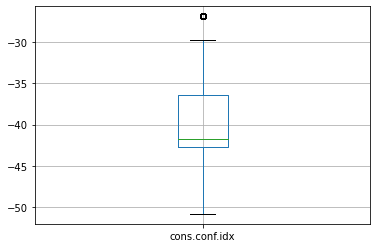

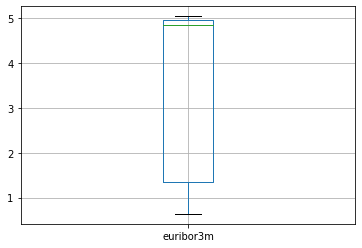

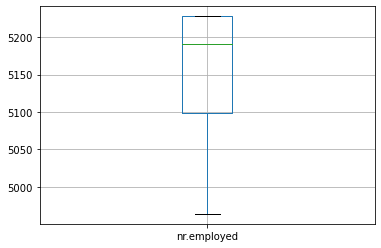

In [16]:
for column in term_num:
    plt.figure()
    term_num.boxplot([column])

In [17]:
print(term.shape[0])

term = Data_Auditor.Remove_Outlier(term,0.2,0.98)

print(term.shape[0])

41188
31021


In [18]:
y = term['y_yes']
X = term.drop('y_yes', axis=1)

from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(X,y, train_size = 0.8,
                                      test_size = 0.2, random_state = 100)

In [19]:
from sklearn.preprocessing import MinMaxScaler as mms

scaler = mms()

Scaling_variable = term_num.columns

X_train[Scaling_variable] = scaler.fit_transform(X_train[Scaling_variable])
X_train.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,P_days_Not_Contacted,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
30196,0,0,1,0,0,0,0,0,0,0,...,1,0.758621,0.008337,0.000000,0.000000,0.333333,0.340608,0.154812,0.165722,0.512287
17487,0,0,0,0,0,0,0,0,1,0,...,1,0.517241,0.102074,0.018182,0.000000,1.000000,0.669135,0.338912,0.981183,1.000000
7219,1,0,0,0,0,0,0,0,0,0,...,1,0.103448,0.078487,0.018182,0.000000,0.937500,0.698753,0.602510,0.958059,0.859735
37872,0,0,0,0,0,0,0,0,1,0,...,1,0.137931,0.012607,0.000000,0.142857,0.104167,0.000000,0.811715,0.042394,0.425709
7397,0,0,0,0,0,0,1,0,0,0,...,1,0.275862,0.154941,0.036364,0.000000,0.937500,0.698753,0.602510,0.958966,0.859735


In [20]:
X_test[Scaling_variable] = scaler.transform(X_test[Scaling_variable])

# Model Building

In [21]:


model = SVC (C=1)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [22]:
from sklearn import metrics
metrics.confusion_matrix(y_true= y_test, y_pred=y_pred)

array([[5548,   46],
       [ 505,  106]], dtype=int64)

In [23]:
print("accuracy", metrics.accuracy_score(y_test, y_pred))

accuracy 0.9112006446414183


In [24]:


params = {"C": [0.1,1,10,100]}

model = SVC()

model_cv = GridSearchCV(estimator= model, param_grid= params,
                       scoring='accuracy',
                       cv=5,
                       verbose=1,
                       n_jobs=-1,
                       return_train_score= True)


In [25]:
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100]}, return_train_score=True,
             scoring='accuracy', verbose=1)

In [26]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,20.276705,0.501798,2.704039,0.246093,0.1,{'C': 0.1},0.914182,0.911344,0.914568,0.915172,...,0.913967,0.001349,3,0.914114,0.914774,0.913917,0.913716,0.914068,0.914118,0.000356
1,20.817772,0.587443,2.677915,0.280928,1,{'C': 1},0.916197,0.914568,0.915374,0.918396,...,0.916304,0.001322,2,0.919907,0.919861,0.919357,0.919811,0.918954,0.919578,0.000369
2,25.646534,0.960807,2.166438,0.369241,10,{'C': 10},0.921031,0.917993,0.918195,0.922224,...,0.919366,0.001903,1,0.950131,0.950536,0.950385,0.948773,0.951342,0.950234,0.000835
3,40.220739,6.580765,1.302600,0.320933,100,{'C': 100},0.917204,0.910135,0.913963,0.907717,...,0.910703,0.004488,4,0.977181,0.977434,0.978240,0.978593,0.977182,0.977726,0.000582


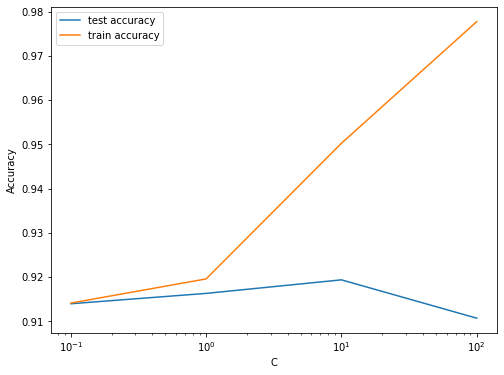

In [27]:
plt.figure(figsize=(8,6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy','train accuracy'], loc='upper left')
plt.xscale('log')


In [28]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test accuracy is {0} at C = {1}".format(best_score, best_C))

 The highest test accuracy is 0.9193664706255784 at C = 10


In [29]:
# model with the best value of C
model = SVC(C=best_C)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [30]:
# metrics
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

accuracy 0.9189363416599516


In [31]:
# specify params
params = {"C": [1, 10],
          "kernel":['linear', 'poly', 'rbf'],
          "gamma":['scale','auto'],
         "class_weight":['balanced']}

# specify scores/metrics in an iterable
scores = ['accuracy', 'precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for {}".format(score))
    
    # set up GridSearch for score metric
    clf = GridSearchCV(SVC(), 
                       params, 
                       cv=5,
                       scoring=score,
                       verbose = 1,
                       n_jobs = -1,
                       return_train_score=True)
    # fit
    clf.fit(X_train, y_train)

    print(" The highest {0} score is {1} at C = {2}".format(score, clf.best_score_, clf.best_params_))
    print("\n")

# Tuning hyper-parameters for accuracy
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.0min finished


 The highest accuracy score is 0.8856380730702931 at C = {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


# Tuning hyper-parameters for precision
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.1min finished


 The highest precision score is 0.4329850606177579 at C = {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


# Tuning hyper-parameters for recall
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.7min finished


 The highest recall score is 0.9070687541261906 at C = {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}




In [32]:
best_model = SVC(C= 10,
                 gamma='scale',
                 kernel='rbf',
                class_weight = 'balanced')

best_model

SVC(C=10, class_weight='balanced')

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.8873489121676068
0.4574468085106383
0.7741407528641571
